In [1]:
# apattion to: https://www.strollswithmydog.com/raw-file-conversion-steps/


In [2]:
%matplotlib inline
import matplotlib as mlp
mlp.rcParams['figure.figsize'] = 10, 15
import matplotlib.pyplot as plt

In [3]:
import rawpy
import numpy as np

In [4]:
raw = rawpy.imread("./hq_cam_color_checker_new.dng")


In [5]:
# step 1: black level correction
# step 2: White Balance the data
# step 3: Correct linear brightness
# step 4: Properly Clip image data
# step 5: Demosaic it
# step 6: Apply Color Transforms and Corrections
# step 7: Apply Gamma

In [6]:
# every step will be performed in the postprocess function
# this function converts the raw image to a rgb image

# start linear conversion
# black level correction
# user_black=None # int

# white balance
# use_camera_wb=True
# or correct the white blance based on a gray card


# correct linear brightness
# no_auto_bright=True
# output_bps=16

# clip image data
# highlight_mode=HighlightMode.Clip # == default

# demosaic
# demosaic_algorithm=None # default is AHD


# apply color transformation
# output_color=ColorSpace.sRGB # == default

# start non linear conversion
# apply gamma
# gamma=(,)
# pair (power,slope), default is (2.222, 4.5)

# get an array after the postprocess function

# last step?
# rgb data to float or int values?

In [7]:
# fill the postprocessfunction with arguments
# leave default arguments as default
rgb_array = raw.postprocess(output_color=rawpy.ColorSpace.raw, 
                            output_bps=16, no_auto_bright=True)
#plt.imshow(rgb_array, vmin=0, vmax=65536)
#plt.show()
print(rgb_array.dtype)
# normalize 0 to 1
max_val = 65536
min_val = 0
print(max_val, min_val)
rgb_array_norm =  rgb_array/(max_val-min_val)

uint16
65536 0


0.8588104248046875 0.0092010498046875


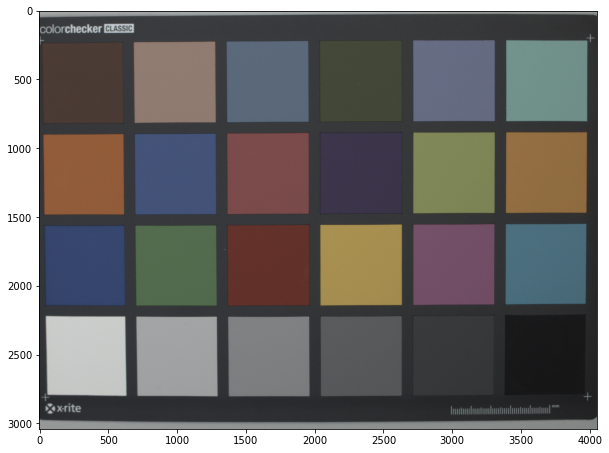

In [8]:
max_rgb = np.max(rgb_array_norm)
min_rgb = np.min(rgb_array_norm)

print(max_rgb, min_rgb)
plt.imshow(rgb_array_norm)

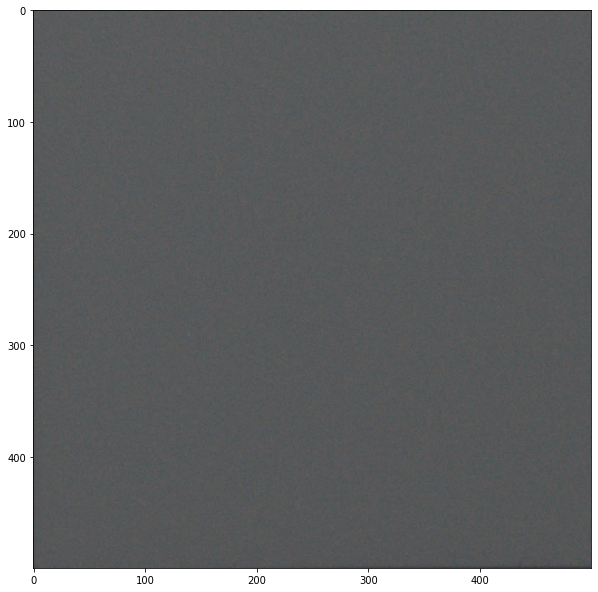

In [9]:
array_crop = rgb_array_norm[2300:2800, 2050:2550] # grey field #D4
# field 4 last line [y1:y2,x1:x2] 500x500
plt.imshow(array_crop)

In [10]:
r_mean = np.mean(array_crop[:,:,0])
g_mean = np.mean(array_crop[:,:,1])
b_mean = np.mean(array_crop[:,:,2])
print(r_mean, g_mean, b_mean)
# Target 122, 122, 121

# camera white balance
# with out user_black: 85.0 89.0 91.0
# with user_black=256: 85.0 89.0 91.0

# auto white balance: 77.0 88.0 95.0

0.3425028430175781 0.34905778240966795 0.35279328997802734


In [11]:
norm_col = b_mean
base_wb = [norm_col/r_mean, norm_col/g_mean, norm_col/b_mean, 1.0]
print(base_wb)

[1.0300448512187126, 1.0107016882493547, 1.0, 1.0]


In [12]:
base_brightness = 1.0/norm_col

print(base_brightness)

2.834521030891154


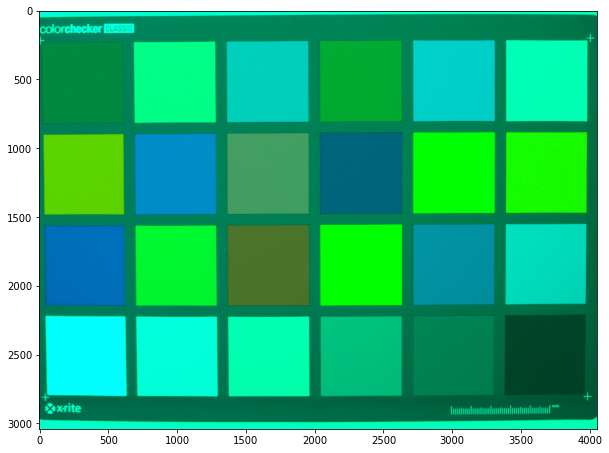

In [13]:
array_corr = raw.postprocess(user_black=256,user_wb=base_wb,
                             bright=base_brightness, no_auto_bright=True)
plt.imshow(array_corr)

0.0 190.79134 124.640572


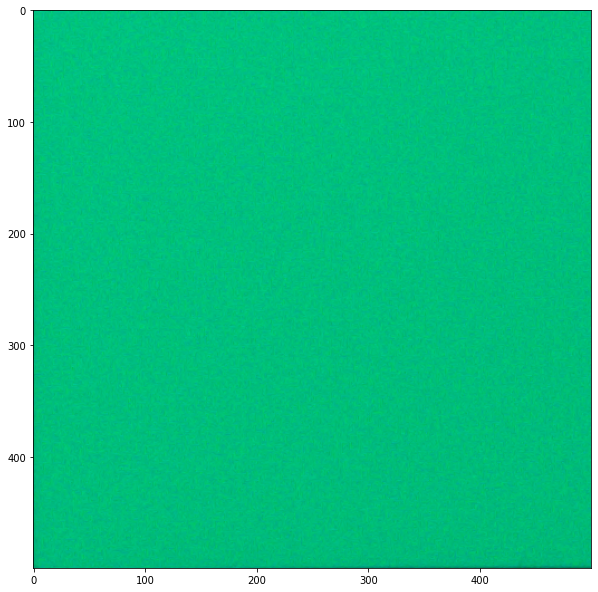

In [14]:
array_crop_corr = array_corr[2300:2800, 2050:2550] # grey field #D4
# field 4 last line [y1:y2,x1:x2] 500x500
plt.imshow(array_crop_corr)

# calculate RGB for on cropped and corrected grey field
r_mean_cc = np.mean(array_crop_corr[:,:,0])
g_mean_cc = np.mean(array_crop_corr[:,:,1])
b_mean_cc = np.mean(array_crop_corr[:,:,2])
print(r_mean_cc, g_mean_cc, b_mean_cc)
# target values [R=122,G=122,B=121]